In [1]:
import timm
import torch
from timm.models.vision_transformer import VisionTransformer
from torch.utils.data import Dataset,DataLoader
import random
import scipy.io as scio
from timm.scheduler.cosine_lr import CosineLRScheduler
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import os
import cv2

In [2]:
class MyDataset(Dataset):
    def __init__(self,data,topk=10):
        self.data=data
        self.topk=topk
        self.label={
            'T-T':2,
            'P-T':1,
            'P-P':0
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path_1,label=self.data[idx]
        image=scio.loadmat(path_1)['fc'] #load FC
        image=torch.from_numpy(image).float()

        path_2=path_1.replace('fc','sc')
        mask=scio.loadmat(path_2)['sc']  #load SC
        mask=mask*1.0
        mask=torch.from_numpy(mask)
        mask=mask.sum(dim=1)
        _,index=torch.topk(mask,10)   
        mask=torch.tensor([i in index for i in range(64)])
        
        label=torch.tensor(self.label[label])
        return image,mask,label

In [3]:
with open('your subject list.txt','r') as f:  #load subject list
    data=f.readlines()
data=[item.replace('\n','').split('\t') for item in data]
random.seed(2022)
random.shuffle(data)

dataset=MyDataset(data)
dataloader=DataLoader(dataset,1)

In [4]:
class MaskViT(VisionTransformer):
    def __init__(self,layer=None):
        super().__init__(patch_size=16, embed_dim=384, depth=12, num_heads=6,num_classes=3)
        if layer is None:
            self.layer=11
        else:
            self.layer=layer

    def forward_with_mask(self,x,mask):

        x = self.patch_embed(x)
        #（B,N,C)
        B,num_patches=x.shape[0],x.shape[1]
        mask_size=mask.sum()//x.shape[0]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # cls_tokens impl from Phil Wang, thanks
        # (B,1,C)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
            cls_token_nums=1
        x = self.pos_drop(x + self.pos_embed)
        res_x = torch.masked_select(x[:,cls_token_nums:,:],mask.reshape(x.shape[0],x.shape[1]-cls_token_nums,1))
        # (B*mask_size,C)
        res_x = res_x.reshape(x.shape[0],mask.sum()//x.shape[0],-1)
        # (B,mask_size,C)
        res_x = torch.cat((cls_token,res_x),dim=1)
        #(B,mask_size+1,C)
        for i in range(self.layer):
            res_x=self.blocks[i](res_x)


        index=torch.range(0,x.shape[0]*(x.shape[1]-cls_token_nums)-1,dtype=torch.int64,device=mask.device)
        index=index.reshape(x.shape[0],-1)
        index=torch.masked_select(index,mask.reshape(x.shape[0],-1))

        cls_token = res_x[:,:cls_token_nums,:]
        res_x = res_x[:,cls_token_nums:,:]
        # (b,patch_nums+1)->(n,patch_nums)
        res_x = res_x.reshape(B*mask_size,-1)
        x = x[:,cls_token_nums:,:]
        x = x.reshape(x.shape[0]*num_patches,-1)
        x = x.index_add_(0,index,res_x)
        x = x.reshape(B,num_patches,-1)
        x = torch.cat((cls_token,x),dim=1)
        for i in range(self.layer,len(self.blocks)):
            x = self.blocks[i](x)
        x = self.norm(x)
        return self.head(x[:,0])
        
mymodel=MaskViT(6) #add to the last layer, can change
ViTmodel=timm.create_model('vit_small_patch16_224',pretrained=True,num_classes=3)
pretrain_weight=ViTmodel.state_dict()
mymodel.load_state_dict(pretrain_weight)
mymodel.patch_embed=torch.nn.Linear(64,384)
mymodel.pos_embed=torch.nn.Parameter(torch.zeros(1, 64+1, 384))

In [5]:
# 定义获取梯度的函数
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].clone().detach())

# 定义获取特征图的函数
def forward_hook(module, input, output):
    feature_block.append(output)

In [6]:
mymodel.load_state_dict(torch.load('well_trained_scg_vit.pth'))
device=torch.device('cpu')
model=mymodel.to(device)
model.patch_embed.register_forward_hook(forward_hook)
model.patch_embed.register_backward_hook(backward_hook)

In [7]:
# forward 
# 在前向推理时，会生成特征图和预测值
grads_val_mean=0.
feature_map_mean=0.
for fc,mask,label in dataloader:
    grad_block=[]
    feature_block=[]
    fc=fc.to(device)
    mask=mask.to(device)
    fc.requires_grad=True
    pred = model(fc)
    max_idx = np.argmax(pred.cpu().data.numpy())
    # print("predict:{}".format(max_idx))

    # backward
    model.zero_grad()
    # 取最大类别的值作为loss，这样计算的结果是模型对该类最感兴趣的cam图
    class_loss = pred[0, max_idx]	
    class_loss.backward()	# 反向梯度，得到梯度图

    # grads
    grads_val = grad_block[0].cpu().data.squeeze()
    feature_map = feature_block[0].cpu().data.squeeze()

    grads_val_mean=grads_val_mean+grads_val
    feature_map_mean=feature_map_mean+feature_map

grads_val_mean=grads_val_mean/len(dataloader)
feature_map_mean=feature_map/len(dataloader) 

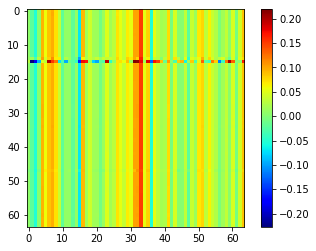

In [8]:
# print(grads_val_mean.shape)
linear_w=mymodel.patch_embed.weight.detach() #(384,64)
# print(linear_w.shape)
linear_b=mymodel.patch_embed.bias.detach()
# print(linear_b.shape)

# linear_W_Rinv=linear_W * ((linear_W.t() * linear_W).inverse())
out1=torch.mm(linear_w.t(),linear_w) #(64,64)   torch.mm(A,B) means matrix A multiply matrix B
linear_w_Rinv=torch.mm(linear_w,out1.inverse()) #(384,64)
input_x=torch.mm(grads_val_mean,linear_w_Rinv) - torch.mm(linear_b.repeat(64,1),linear_w_Rinv)
# print(input_x)

import matplotlib.pyplot as plt
plt.imshow(input_x,cmap = plt.cm.jet)
plt.colorbar()